# **Connecting the dots**

## [Riddler Classic](https://fivethirtyeight.com/features/can-you-connect-the-dots/), Jun 26, 2020

### solution by [Laurent Lessard](https://laurentlessard.com)

The data files used in my solution can be found on the website of [Oswin Aichholzer](http://www.ist.tugraz.at/staff/aichholzer/research/rp/triangulations/ordertypes/)

For more details on the problem, see my write-up [here](https://laurentlessard.com/bookproofs/connect-the-dots/)

In [1]:
from itertools import permutations,combinations
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# simple class to represent a point in the plane
class Point:
    def __init__(self, x, y):
        self.x, self.y = x, y
    def __add__(self, other):
        return Point(self.x + other.x, self.y + other.y)
    def __sub__(self, other):
        return Point(self.x - other.x, self.y - other.y)
    def __neg__(self):
        return Point(-self.x, -self.y)
    def __pos__(self):
        return Point(self.x, self.y)
    def __eq__(self, other):
        return (self.x == other.x) and (self.y == other.y)
    def __ne__(self, other):
        return (self.x != other.x) or (self.y != other.y)
    def __repr__(self):
        return "Point([{0},{1}])".format(self.x, self.y)
    def __str__(self):
        return "x: {0}, y: {1}".format(self.x, self.y)

# each edge is a pair of points. Do these two edges intersect?
# note: we exclude cases where intersection occurs at a vertex
def is_intersecting(edge1, edge2):
    p1,p2 = edge1
    q1,q2 = edge2
    
    # no duplicate nodes allowed
    if p1 == q1 or p1 == q2 or p2 == q1 or p2 == q2:
        return False
    
    A = np.array([[(p2-p1).x, (q1-q2).x],
                  [(p2-p1).y, (q1-q2).y]])
    b = np.array([[(q1-p1).x], [(q1-p1).y]])
    t,s = np.linalg.solve(A, b)
    return (0 < t < 1) and (0 < s < 1)

# extract list of Points from an ordertype
def get_point_list(ordertype):
    xs = ordertype[0::2]
    ys = ordertype[1::2]
    return [Point(int(xs[i]),int(ys[i])) for i in range(len(xs))]

# extract list of edges for a given cycle
def get_edge_list(pointlist, cycle):
    n = len(cycle)
    # list of edges that are used by this cycle
    return [ (pointlist[cycle[i]],pointlist[cycle[(i+1) % n]]) for i in range(n) ]

# given a pointlist and a point ordering, say if there are intersecting edges
def is_nonintersecting_cycle(pointlist, cycle):
    edgelist = get_edge_list(pointlist, cycle)
    for e1,e2 in combinations(edgelist,2):
        if is_intersecting(e1,e2):
            return False
    return True

# return list of nonintersecting cycles
def get_nonintersecting_cycles(pointlist):
    n = len(pointlist)
    nic = []
    for c in [c for c in permutations(range(1,n)) if c[0] < c[-1]]:
        # cycle starts with zero
        cycle = (0, *c)
        if is_nonintersecting_cycle(pointlist,cycle):
            nic.append(cycle)
    return nic

def get_crossing_number(pointlist):
    n = len(pointlist)
    edgelist = combinations(pointlist,2)
    edgepairs = combinations(edgelist,2)
    return len( [1 for e1,e2 in edgepairs if is_intersecting(e1,e2)] )

In [6]:
%%time
n = 6  # number of points

# load the data file. Here S is a list of pointlists (each corresponding to a distinct ordertype)
f = open(f"connect_the_dots_data/otypes0{n}.b08", "r")
raw = np.fromfile(f, dtype=np.uint8)
ordertypes = raw.reshape(-1,2*n)
S = [get_point_list(ordertype) for ordertype in ordertypes]

# count cycles and crossing number. Arrange results sorted by crossing number        
num_cycles = [len(get_nonintersecting_cycles(pointlist)) for pointlist in S]
crossing_number = [get_crossing_number(pointlist) for pointlist in S]

ixsort = np.argsort(crossing_number)
S = [S[i] for i in ixsort]
num_cycles = [num_cycles[i] for i in ixsort]
crossing_number = [crossing_number[i] for i in ixsort]
print(len(S))

16
Wall time: 324 ms


In [4]:
def plot_graph(pointlist,ax, show_edges=True, show_nodes=True):
    
    # x and y coordinates of the points
    x = [p.x for p in pointlist]
    y = [p.y for p in pointlist]
    
    # enumerate all pairs of dots and plot connecting lines
    if show_edges:
        for p,q in combinations(pointlist,2):
            ax.plot([p.x,q.x], [p.y,q.y], "k-")
    
    # plot each of the points individually
    if show_nodes:
        ax.plot(x,y,".",markersize=18)
    
    ax.axis("equal")

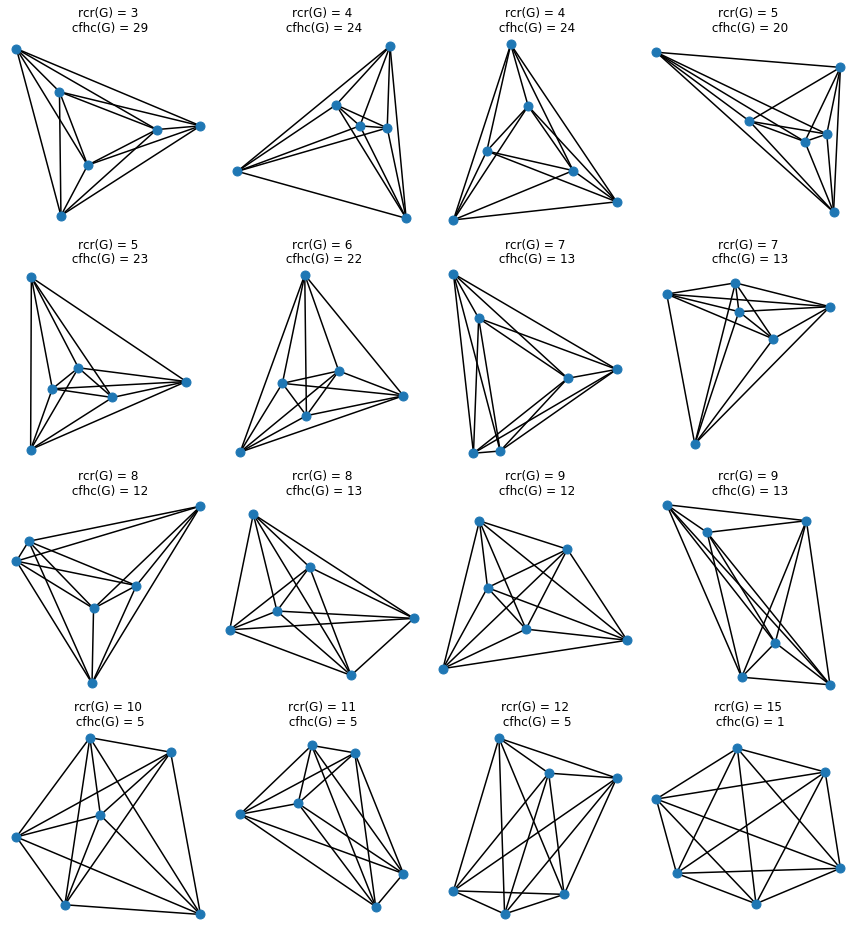

In [5]:
# Share both X and Y axes with all subplots
# fig,axs = plt.subplots(1,2, figsize=(8,5)) # n=4
# fig,axs = plt.subplots(1,3, figsize=(12,5)) # n=5
fig,axs = plt.subplots(4,4, figsize=(12,13)) # n=6
# fig,axs = plt.subplots(27,5, figsize=(16,88)) # n=7

for ix,pointlist in enumerate(S):
    ax = axs.reshape(-1)[ix]
    plot_graph(pointlist,ax)
    ax.set_title(f"rcr(G) = {crossing_number[ix]}\n cfhc(G) = {num_cycles[ix]}")

for ax in axs.reshape(-1):
    ax.axis("off")
plt.tight_layout()
plt.savefig(f"connect_the_dots_img/connect_K{n}.png",pad_inches=0)

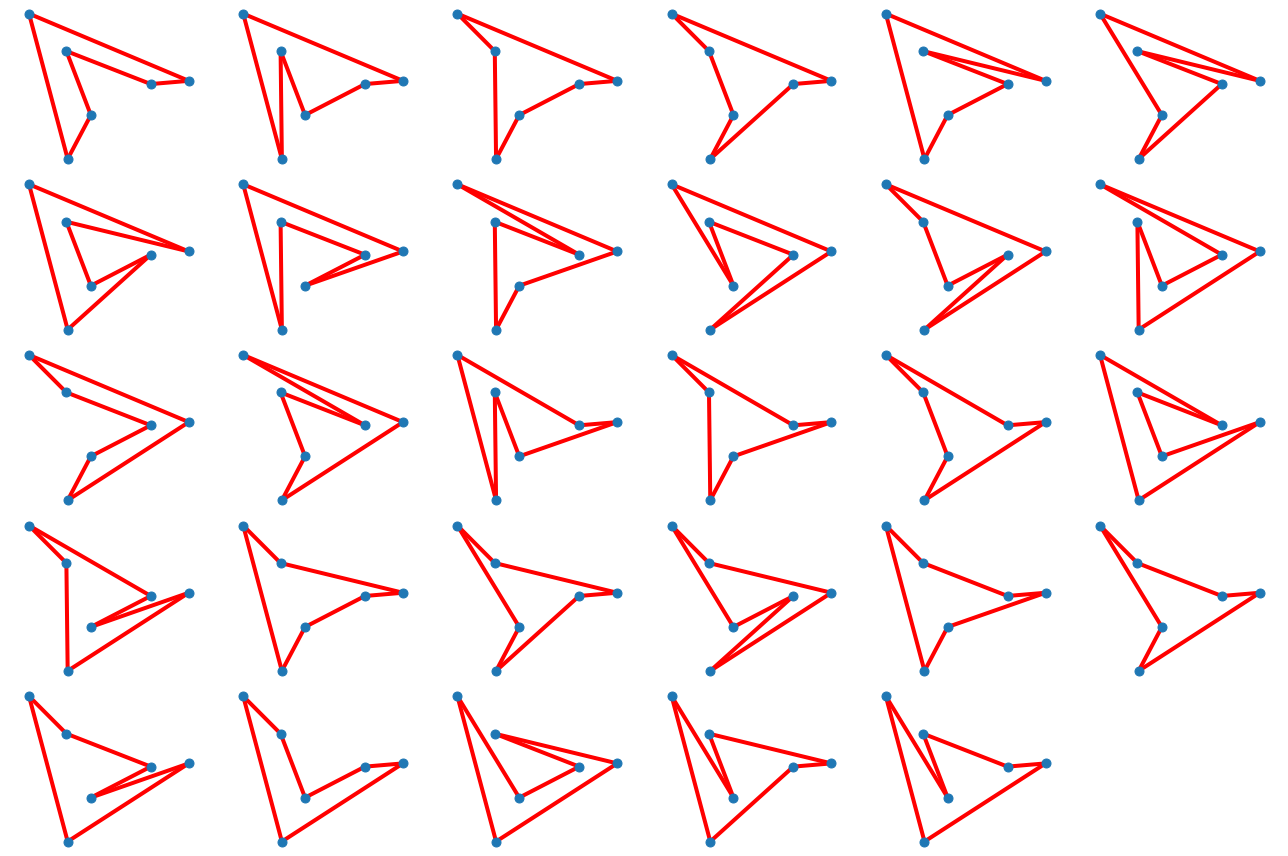

In [8]:
# pick the order type with most CFHC (crossing-free Hamiltonian circuits)
pointlist = S[np.argmax(num_cycles)]

n = len(pointlist)
cycles = get_nonintersecting_cycles(pointlist)

# fig,axs = plt.subplots(1,3, figsize=(9,3)) # n=4
# fig,axs = plt.subplots(2,4, figsize=(15,7)) # n=5
fig,axs = plt.subplots(5,6, figsize=(18,12)) # n=6
# fig,axs = plt.subplots(16,6, figsize=(20,40)) # n=7

for ix,c in enumerate(cycles):
    ax = axs.reshape(-1)[ix]
    
    for i in range(n):
        p1 = pointlist[c[i]]
        p2 = pointlist[c[(i+1) % n]]
        ax.plot( [p1.x, p2.x], [p1.y, p2.y], "r-", linewidth=4)
        
    plot_graph(pointlist,ax, show_edges=False)
    
for ax in axs.reshape(-1):
    ax.axis("off")
    
plt.tight_layout()
plt.savefig(f"connect_the_dots_img/connect_K{n}_paths.png")